In [2]:
import os
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Problem Summary

An ongoing problem that has arisen as the result of generative AI is the ability to generate "deepfake" images that resemble real photographs. Identifying these images reliably, without missing any, can help limit the negative impact that they have in misleading people into believing that they are real.

It is expected that in a real-world scenario, most images that we encounter are real images, and therefore accuracy is a skewed metric to use for a first pass; we care primarily about identifying all "deepfakes" correctly, even at the cost of identifying some false positives. If we had a model that could do this, this set of "mostly deepfakes" could then be passed on to another model that is more optimized for a standard measure such as accuracy or F1 that will identify false positives more accurately.

In this project we will use the CIFAKE dataset (included in the references below) to experiment with different model architectures and weights to determine if we can reliably improve our ability to identify deepfakes without negatively impacting our overall accuracy. 

# Exploratory Data Analysis (EDA)

In [4]:
train_dir = 'data/train'
test_dir = 'data/test'

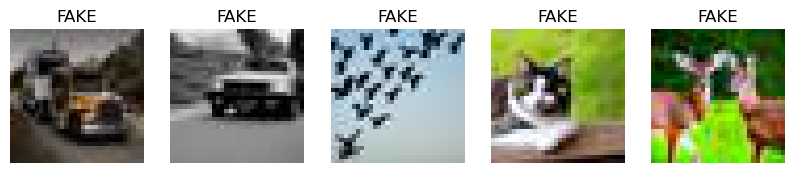

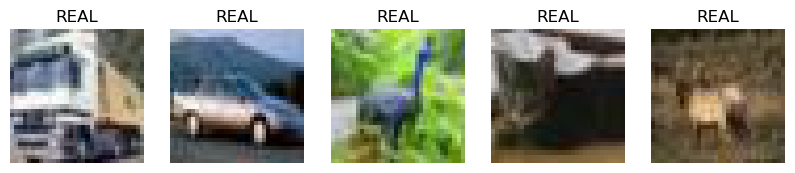

In [6]:
# display some real images and some fake images
from keras.preprocessing.image import load_img, img_to_array

for cat in ['FAKE','REAL']:
    cat_dir = os.path.join(train_dir, cat)
    image_files = os.listdir(cat_dir)[:5]

    plt.figure(figsize=(10, 10))

    for i, image_file in enumerate(image_files):
        img_path = os.path.join(cat_dir, image_file)
        img = load_img(img_path, target_size=(32, 32))
        img_array = img_to_array(img)

        plt.subplot(1, 5, i+1)
        plt.imshow(np.uint8(img_array))
        plt.title(cat)
        plt.axis('off')

    plt.show()

In [8]:
# read in training and test data
train_images, val_images = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    class_names = ['REAL','FAKE'], #fake images are the "relevant" instances here
    batch_size=32,
    image_size=(32, 32),
    shuffle=True,
    seed=42,
    validation_split=.2,
    subset="both",
    verbose=True # print some basic information about the images
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    class_names = ['REAL','FAKE'], #fake images are the "relevant" instances here
    batch_size=32,
    image_size=(32, 32),
    shuffle=True,
    seed=42,
    verbose=True # print some basic information about the images
)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Using 20000 files for validation.
Found 20000 files belonging to 2 classes.


# Model Training

In [5]:
from tensorflow.keras import models, layers, metrics
from tensorflow.keras import Model

## Basic Convolutional Model

In [6]:
# basic convnet
basic_model = models.Sequential([
    layers.Input(shape=[32, 32, 3]),
    layers.Rescaling(1.0 / 255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

basic_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(name="acc"),metrics.AUC(name="auc"), metrics.Recall(name="recall"), metrics.Precision(name="precision")])

basic_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,913 (605.13 KB)

 Trainable params: 154,913 (605.13 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
basic_history = basic_model.fit(train_images, validation_data = val_images, epochs = 20)

#save model
basic_model.save('models/basic.keras')

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 87s 33ms/step - acc: 0.6246 - auc: 0.6758 - loss: 0.6372 - precision: 0.6489 - recall: 0.5015 - val_acc: 0.8005 - val_auc: 0.8836 - val_loss: 0.4303 - val_precision: 0.8108 - val_recall: 0.7802
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - acc: 0.8162 - auc: 0.8979 - loss: 0.4055 - precision: 0.8323 - recall: 0.7907 - val_acc: 0.8467 - val_auc: 0.9258 - val_loss: 0.3562 - val_precision: 0.8911 - val_recall: 0.7874
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - acc: 0.8556 - auc: 0.9311 - loss: 0.3359 - precision: 0.8683 - recall: 0.8374 - val_acc: 0.8765 - val_auc: 0.9495 - val_loss: 0.3045 - val_precision: 0.8456 - val_recall: 0.9190
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - acc: 0.8800 - auc: 0.9493 - loss: 0.2886 - precision: 0.8865 - recall: 0.8708 - val_acc: 0.8946 - val_auc: 0.9589 - val_loss: 0.2645 - val_precision: 0.8845 - val_recall: 0.9061
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - ac

In [8]:
weighted_model = models.Sequential([
    layers.Input(shape=[32, 32, 3]),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
weighted_model.summary()

weighted_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(name="acc"),metrics.AUC(name="auc"), metrics.Recall(name="recall"), metrics.Precision(name="precision")])

weighted_history = weighted_model.fit(train_images, validation_data = val_images,
                class_weight ={0: .3,1: .7}, # try again, but this time we care more about correctly distinguishing fake images   
                epochs = 20)

# Save model
weighted_model.save('models/weighted.keras')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,913 (605.13 KB)

 Trainable params: 154,913 (605.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - acc: 0.5122 - auc: 0.6384 - loss: 0.2942 - precision: 0.5054 - recall: 0.9930 - val_acc: 0.7256 - val_auc: 0.8298 - val_loss: 0.5512 - val_precision: 0.6667 - val_recall: 0.8947
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - acc: 0.7310 - auc: 0.8513 - loss: 0.2147 - precision: 0.6685 - recall: 0.9150 - val_acc: 0.7883 - val_auc: 0.8872 - val_loss: 0.4696 - val_precision: 0.7350 - val_recall: 0.8972
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - acc: 0.7944 - auc: 0.8968 - loss: 0.1834 - precision: 0.7399 - recall: 0.9058 - val_acc: 0.8397 - val_auc: 0.9160 - val_loss: 0.3817 - val_precision: 0.8309 - val_recall: 0.8503
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - acc: 0.8283 - auc: 0.9193 - loss: 0.1644 - precision: 0.7802 - recall: 0.9129 - val_acc: 0.8299 - val_auc: 0.9308 - val_loss: 0.4116 - val_precision: 0.7675 - val_recall: 0.9433
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - acc

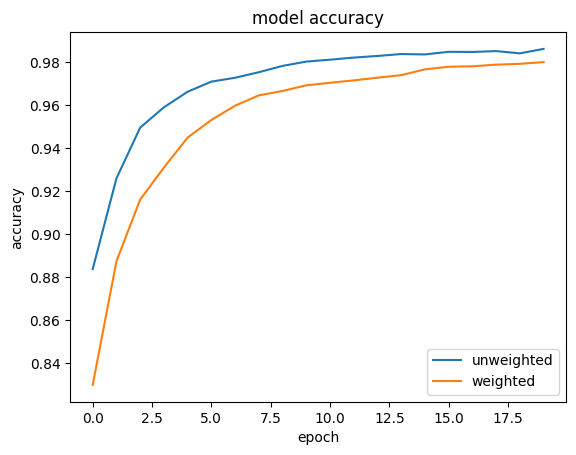

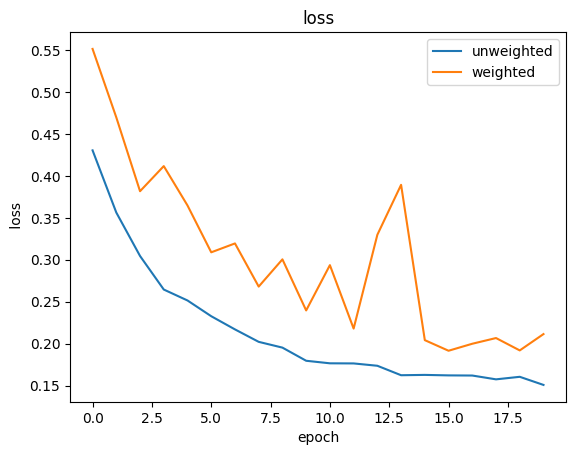

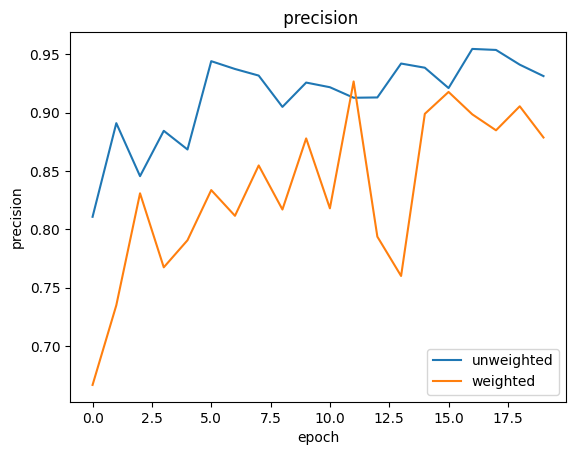

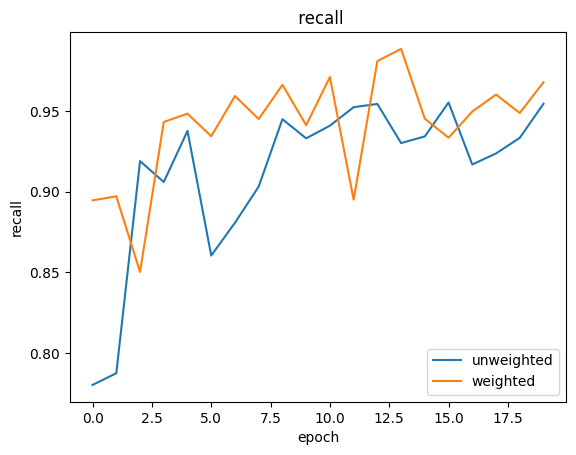

In [10]:
plt.plot(basic_history.history['val_auc'])
plt.plot(weighted_history.history['val_auc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['unweighted', 'weighted'], loc='lower right')
plt.show()

plt.plot(basic_history.history['val_loss'])
plt.plot(weighted_history.history['val_loss'])
plt.title('loss')
plt.ylabel(' loss')
plt.xlabel('epoch')
plt.legend(['unweighted', 'weighted'], loc='upper right')
plt.show()

plt.plot(basic_history.history['val_precision'])
plt.plot(weighted_history.history['val_precision'])
plt.title(' precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['unweighted', 'weighted'], loc='lower right')
plt.show()

plt.plot(basic_history.history['val_recall'])
plt.plot(weighted_history.history['val_recall'])
plt.title(' recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['unweighted', 'weighted'], loc='lower right')
plt.show()

As we expect, the precision is better for the unweighted model and the recall is better for the weighted model. The overall accuracy (AUC) for the unweighted model is better, but neither the precision nor the accuracy have suffered catastrophically.

## Transfer Learning

Now, we're going to compare our simple model to some pre-build classifier models using transfer learning. These models, which are designed to identify different types of images , may nonetheless perform well in classifying fake images due to the large amount of data they've been trained on.

In [11]:
from tensorflow.keras.applications import VGG19, ResNet50

In [12]:
# transfer learning with VGG

vgg_base_model = tf.keras.applications.VGG19(
    input_shape = (32,32,3),
    include_top = False,
    weights = 'imagenet'
)

vgg_base_model.trainable = False

vgg_model = models.Sequential([
    vgg_base_model,
    layers.Flatten(input_shape=(96, 96)),
    layers.Dense(units=96, activation='relu'),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(1, activation = 'sigmoid')
])
vgg_model.summary()

vgg_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(name="acc"),metrics.AUC(name="auc"), metrics.Recall(name="recall"), metrics.Precision(name="precision")])

vgg_history = vgg_model.fit(train_images, validation_data = val_images, epochs = 20)

# Save model
vgg_model.save('models/vgg.keras')

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 1, 1, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 96)                  │          49,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,076,769 (76.59 MB)

 Trainable params: 52,385 (204.63 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - acc: 0.7721 - auc: 0.8466 - loss: 0.5950 - precision: 0.7696 - recall: 0.7722 - val_acc: 0.8325 - val_auc: 0.9101 - val_loss: 0.3807 - val_precision: 0.8229 - val_recall: 0.8443
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - acc: 0.8400 - auc: 0.9191 - loss: 0.3622 - precision: 0.8354 - recall: 0.8454 - val_acc: 0.8422 - val_auc: 0.9210 - val_loss: 0.3585 - val_precision: 0.8356 - val_recall: 0.8494
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - acc: 0.8547 - auc: 0.9309 - loss: 0.3357 - precision: 0.8520 - recall: 0.8573 - val_acc: 0.8405 - val_auc: 0.9224 - val_loss: 0.3598 - val_precision: 0.8173 - val_recall: 0.8741
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - acc: 0.8627 - auc: 0.9384 - loss: 0.3174 - precision: 0.8603 - recall: 0.8649 - val_acc: 0.8504 - val_auc: 0.9289 - val_loss: 0.3410 - val_precision: 0.8425 - val_recall: 0.8595
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step 

In [13]:
# transfer learning with ResNet

rn_base_model = tf.keras.applications.ResNet50(
    input_shape = (32,32,3),
    include_top = False,
    weights = 'imagenet'
)

rn_base_model.trainable = False

rn_model = models.Sequential([
    rn_base_model,
    layers.Flatten(input_shape=(96, 96)),
    layers.Dense(units=96, activation='relu'),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(1, activation = 'sigmoid')
])
rn_model.summary()

rn_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(name="acc"),metrics.AUC(name="auc"), metrics.Recall(name="recall"), metrics.Precision(name="precision")])

rn_history = rn_model.fit(train_images, validation_data = val_images, epochs = 20)

# Save model
rn_model.save('models/rn.keras')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 96)                  │         196,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,787,553 (90.74 MB)

 Trainable params: 199,841 (780.63 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - acc: 0.8242 - auc: 0.9005 - loss: 0.3989 - precision: 0.8279 - recall: 0.8165 - val_acc: 0.8794 - val_auc: 0.9482 - val_loss: 0.2916 - val_precision: 0.8849 - val_recall: 0.8703
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - acc: 0.8814 - auc: 0.9524 - loss: 0.2794 - precision: 0.8810 - recall: 0.8810 - val_acc: 0.8834 - val_auc: 0.9527 - val_loss: 0.2785 - val_precision: 0.8885 - val_recall: 0.8748
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - acc: 0.8930 - auc: 0.9607 - loss: 0.2539 - precision: 0.8927 - recall: 0.8926 - val_acc: 0.8845 - val_auc: 0.9575 - val_loss: 0.2725 - val_precision: 0.8597 - val_recall: 0.9172
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - acc: 0.9011 - auc: 0.9659 - loss: 0.2365 - precision: 0.9007 - recall: 0.9007 - val_acc: 0.8917 - val_auc: 0.9583 - val_loss: 0.2656 - val_precision: 0.9053 - val_recall: 0.8732
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step 

## Comparison of Different Architectures

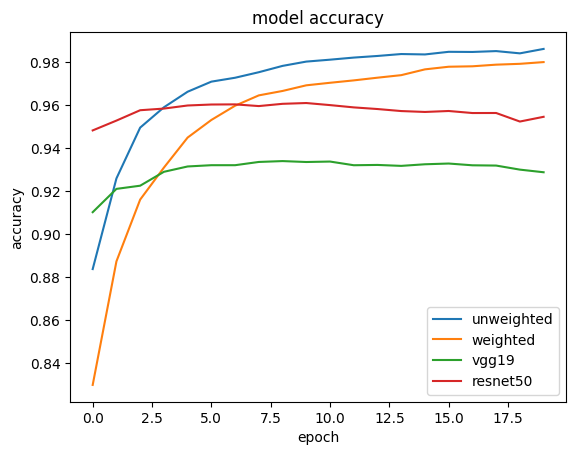

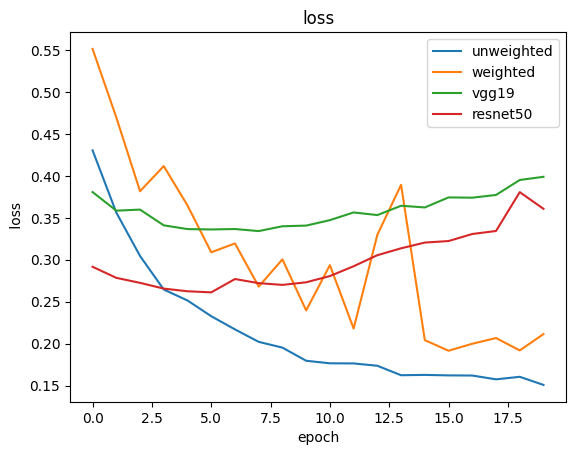

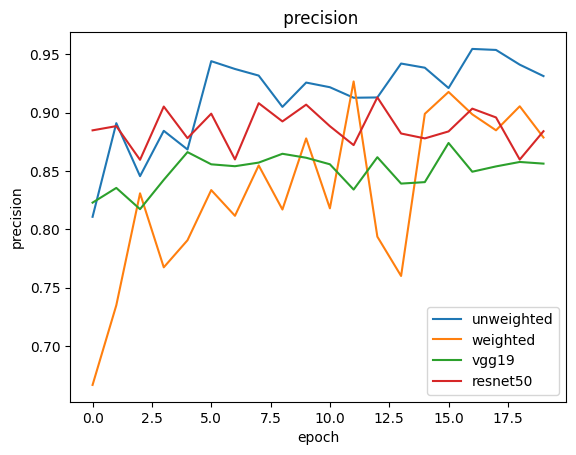

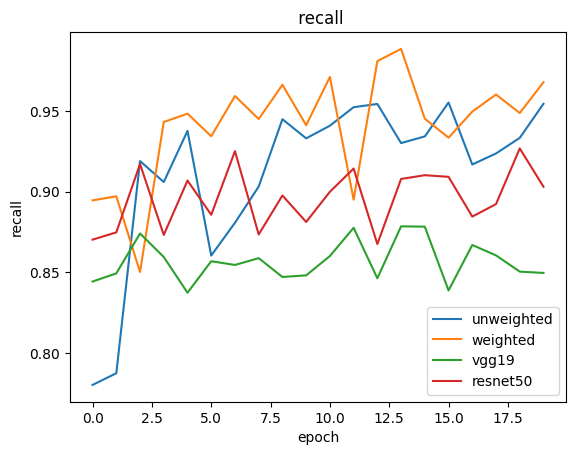

In [14]:
plt.plot(basic_history.history['val_auc'])
plt.plot(weighted_history.history['val_auc'])
plt.plot(vgg_history.history['val_auc'])
plt.plot(rn_history.history['val_auc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['unweighted', 'weighted', 'vgg19', 'resnet50'], loc='lower right')
plt.show()

plt.plot(basic_history.history['val_loss'])
plt.plot(weighted_history.history['val_loss'])
plt.plot(vgg_history.history['val_loss'])
plt.plot(rn_history.history['val_loss'])
plt.title('loss')
plt.ylabel(' loss')
plt.xlabel('epoch')
plt.legend(['unweighted', 'weighted', 'vgg19', 'resnet50'], loc='upper right')
plt.show()

plt.plot(basic_history.history['val_precision'])
plt.plot(weighted_history.history['val_precision'])
plt.plot(vgg_history.history['val_precision'])
plt.plot(rn_history.history['val_precision'])
plt.title(' precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['unweighted', 'weighted','vgg19', 'resnet50'], loc='lower right')
plt.show()

plt.plot(basic_history.history['val_recall'])
plt.plot(weighted_history.history['val_recall'])
plt.plot(vgg_history.history['val_recall'])
plt.plot(rn_history.history['val_recall'])
plt.title(' recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['unweighted', 'weighted','vgg19', 'resnet50'], loc='lower right')
plt.show()

Clearly, transfer learning on pre-built models is not the solution here! the simpler convolutional models perform noticeably better, despite a similar order of magnitude number of trainable parameters

## Hyperparameter Tuning

Using our simpler models, we'll now try to determine the best overall parameters. We'll be minimizing loss despite the fact that we primarily care about recall because recall is not a differentiable parameter, meaning gradient descent will not behave as expected. The parameters we will tune will be the learning rate, and we will also try adding a dropout layer to the densely connected part of the network to see if that improves the results.

In [8]:
import keras_tuner
from keras.callbacks import EarlyStopping #performance tweaking

In [9]:
# hyperparameter tuning with improved model
def build_model(hp):
    
    hp_dropout = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_learning_rate = hp.Choice('dropout', values=[0.0,0.1,0.2,0.3,0.4,0.5])
    
    model = models.Sequential([
        layers.Input(shape=[32, 32, 3]),
        layers.Rescaling(1.0 / 255),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(hp_dropout),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(name="acc"),metrics.AUC(name="auc"), metrics.Recall(name="recall"), metrics.Precision(name="precision")])

    return model

In [12]:
tuner = keras_tuner.RandomSearch(build_model, objective='val_loss', overwrite=True)
tuner.search(train_images, validation_data = val_images, epochs = 20, callbacks=[EarlyStopping(patience=2)])

best_unweighted_model = tuner.get_best_models()[0]
best_unweighted_model.save('/kaggle/working/best.keras')

best_uw_hps=tuner.get_best_hyperparameters()[0]
print(f"""
The hyperparameter search is complete. The optimal dropout rate is {best_uw_hps.get('dropout')} and the optimal learning rate for the optimizer
is {best_uw_hps.get('learning_rate')}.
""")

Trial 10 Complete [00h 03m 12s]
val_loss: 0.6932795643806458

Best val_loss So Far: 0.6913681030273438
Total elapsed time: 00h 27m 43s

The hyperparameter search is complete. The optimal dropout rate is 0.0 and the optimal learning rate for the optimizer
is 0.01.



We found that the optimal learning rate is 0.01, but it looks like a dropout layer didn't improve our model, so we won't use one. Now we'll experiment with these values and different class weights to see how the models compare.

In [14]:
tuned_histories = []
tuned_models = []

for i in range(5):
    fake_weight = .5 + .1*i
    real_weight = .5 - .1*i
    print('Class weights: Fake:'+str(fake_weight)+' Real:'+str(real_weight))
    tuned_model = models.Sequential([
            layers.Input(shape=[32, 32, 3]),
            layers.Rescaling(1.0 / 255),
            layers.Conv2D(16, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
    
    tuned_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.01), #from hyperparameter tuning
                  loss='binary_crossentropy',
                  metrics=[metrics.BinaryAccuracy(name="acc"),metrics.AUC(name="auc"), metrics.Recall(name="recall"), metrics.Precision(name="precision")])
    
    tuned_history = tuned_model.fit(train_images, validation_data = val_images,
                    class_weight ={0:real_weight, 1: fake_weight}, # we're iterating over possible splits from .5/.5 to .1/.9
                    epochs = 20)

    # Save model
    percent = 50+10*i
    num_string = str(percent) + 'percent'    
    tuned_model.save('models/tuned_recall_'+num_string+'.keras')
    tuned_models.append(tuned_model)
    tuned_histories.append(tuned_history)

Class weights: Fake:0.5 Real:0.5
Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 58s 22ms/step - acc: 0.7663 - auc: 0.8447 - loss: 0.2391 - precision: 0.7717 - recall: 0.7570 - val_acc: 0.8694 - val_auc: 0.9432 - val_loss: 0.3206 - val_precision: 0.8547 - val_recall: 0.8878
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - acc: 0.8790 - auc: 0.9480 - loss: 0.1465 - precision: 0.8841 - recall: 0.8713 - val_acc: 0.8841 - val_auc: 0.9558 - val_loss: 0.2821 - val_precision: 0.8656 - val_recall: 0.9074
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - acc: 0.8869 - auc: 0.9547 - loss: 0.1367 - precision: 0.8928 - recall: 0.8784 - val_acc: 0.8747 - val_auc: 0.9487 - val_loss: 0.3093 - val_precision: 0.9042 - val_recall: 0.8363
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - acc: 0.8892 - auc: 0.9568 - loss: 0.1338 - precision: 0.8957 - recall: 0.8803 - val_acc: 0.8712 - val_auc: 0.9582 - val_loss: 0.3222 - val_precision: 0.8196 - val_recall: 0.9496
Epoch 5/20
2500/2500 ━━

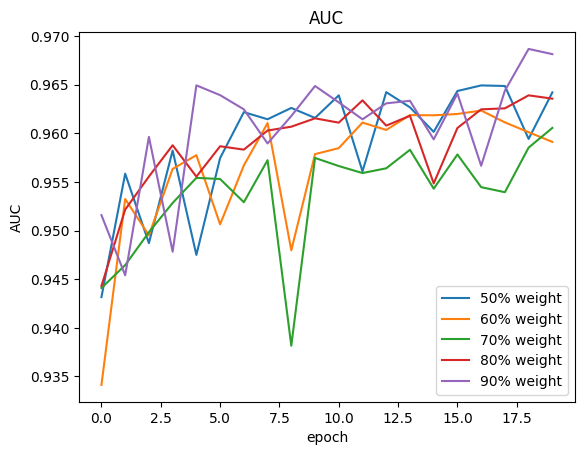

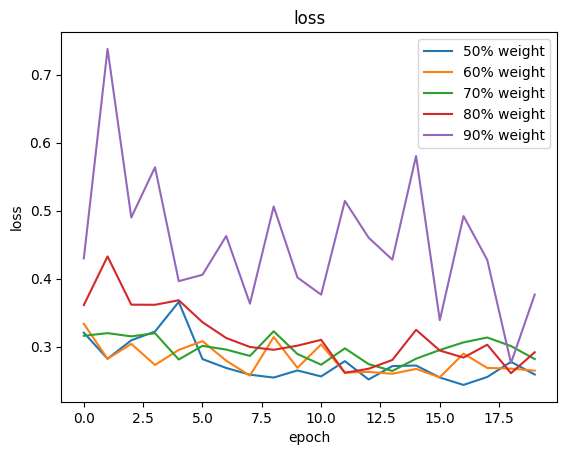

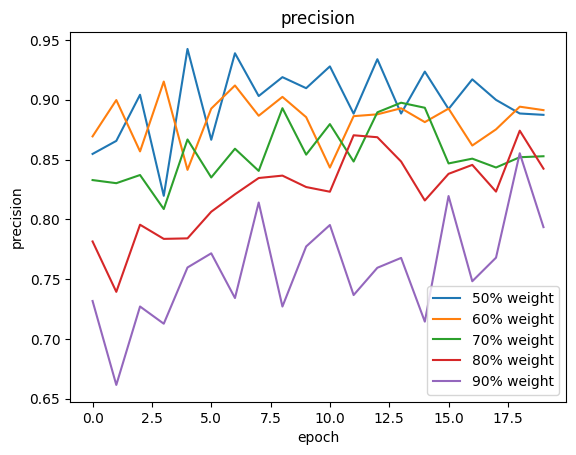

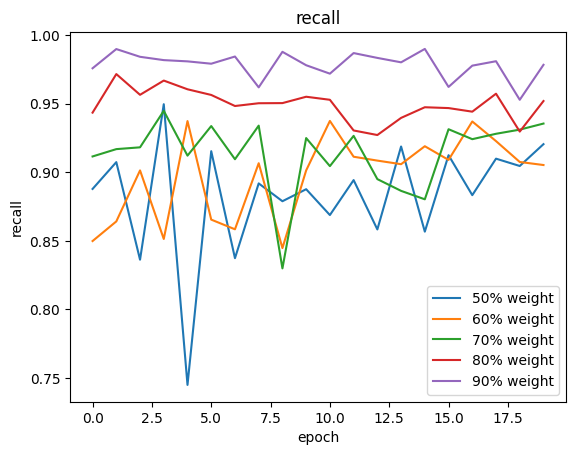

In [23]:
plots = ['val_auc','val_loss','val_precision','val_recall']
titles = ['accuracy','loss','precision','recall']
legends = [str(50+10*i) + '% weight' for i in range(len(tuned_histories))]
locs = ['lower right','upper right','lower right','lower right']

for i in range(len(plots)):
    for history in tuned_histories:
        plt.plot(history.history[plots[i]])
    plt.title(titles[i])
    plt.ylabel(titles[i])
    plt.xlabel('epoch')
    plt.legend(legends, loc=locs[i])
    plt.show()

# Results

In [24]:
# load models
model_list = ['50percent','60percent','70percent','80percent','90percent']

# tuned_models = []
# for name in model_list:
    # fname = 'models/tuned_recall_'+ name + '.keras'
    # load_model = models.load_model(fname)
    # tuned_models.append(load_model)

# evaluate on test data
results = ['Loss:','Binary accuracy:','AUC:','Recall:','Precision:']

for i in range(len(model_list)):
    model = tuned_models[i]
    model_results = model.evaluate(test_images,verbose=0)
    print(model_list[i])
    for j in range(len(results)):
        print(results[j], model_results[j])

50percent
Loss: 0.2465210258960724
Binary accuracy: 0.9070500135421753
AUC: 0.9667170643806458
Recall: 0.9211000204086304
Precision: 0.8959245085716248
60percent
Loss: 0.2608814835548401
Binary accuracy: 0.8949499726295471
AUC: 0.9601171016693115
Recall: 0.9010999798774719
Precision: 0.8901511430740356
70percent
Loss: 0.27744752168655396
Binary accuracy: 0.8870000243186951
AUC: 0.960119366645813
Recall: 0.9318000078201294
Precision: 0.8551762104034424
80percent
Loss: 0.2854503095149994
Binary accuracy: 0.886900007724762
AUC: 0.9635692834854126
Recall: 0.9458000063896179
Precision: 0.8461263179779053
90percent
Loss: 0.371913880109787
Binary accuracy: 0.8657500147819519
AUC: 0.9678453803062439
Recall: 0.9775999784469604
Precision: 0.798888623714447


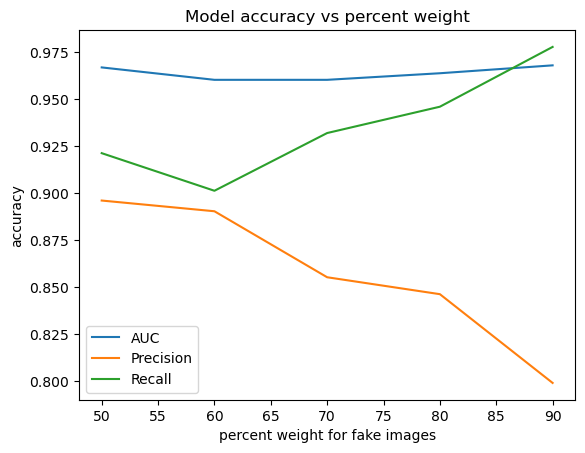

In [18]:
weights = [50,60,70,80,90]
aucs = [.9667,.9601,.9601,.9636,.9678]
pres = [.8959,.8902,.8551,.8461,.7989]
recs = [.9211,.9011,.9318,.9458,.9776]

plt.plot(weights, aucs)
plt.plot(weights, pres)
plt.plot(weights, recs)
plt.xlabel('percent weight for fake images')
plt.ylabel('accuracy')
plt.title("Model accuracy vs percent weight")
plt.legend(['AUC','Precision','Recall'],loc='lower left')
plt.show()


Using our test dataset as a sanity check, these values are largely consistent with the validation data from the training set! Recall is improved at the expence of precision with no measureably difference in overall accuracy as measured by AUC, even when accuracy itself seems to decrease!

# Conclusions

It has been shown that a simple convolutional neural network can be trained to reliably identify "deepfake" images that are indistinguishable to the human eye, and that these models are performant even when compared to using transfer learning with pre-trained models. It has also been shown that adjusting the class weights of real vs. fake images within the model can reliably identify more "fake" images (recall) at the expense of misclassifying some real ones (precision), without too-greatly impacting the overall accuracy: models weighted heavily in favor fake images on average have similar accuracy (AUC) and the tradeoff appears to be one-for-one even up to 90% class weighting.

# References
1. https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
2. https://ieeexplore.ieee.org/abstract/document/10409290
3. https://www.cs.toronto.edu/~kriz/cifar.html
4. https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
5. https://www.kaggle.com/code/givkashi/transfer-learning-with-vgg19